# Attack on CIFAR-10
A quick demonstration

## Loading modules and specifying model location

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Torch
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Foolbox
import foolbox as fb
from foolbox import PyTorchModel
from foolbox.attacks import LinfPGD, FGSM, L0BrendelBethgeAttack, L1BrendelBethgeAttack, L2CarliniWagnerAttack

# Model path
save_path = "models" + os.sep + "CIFAR-10" + os.sep

# Our model and data is put on the GPU if possible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load model
This model was build and pretrained by us.

In [2]:
model = torch.load(save_path + 'reference_model_val_acc=0.8023.pt', 
                   map_location=device)
model.eval()

CIFAR_Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

## Load images and labels

Using image augmentation, which was also used during training

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=1)])

## Loading testset into data loader

In [4]:
testset = CIFAR10(root='./data', download=True, train=False, transform=transform,)
dataloader = DataLoader(testset, batch_size=50) # This object normal

Files already downloaded and verified


Take only the first batch for this demonstration

In [5]:
images, labels = next(iter(dataloader)) # Take first batch, which contains 50 images and labels
images, labels = images.to(device), labels.to(device) # Move to the GPU

### Pytorch: Choose an attack and execute!

In [6]:
attack, attack_kwargs = L0BrendelBethgeAttack(steps=20), {"epsilons": None}
#attack, attack_kwargs = L1BrendelBethgeAttack(steps=20), {"epsilons": None}
#attack, attack_kwargs = L2CarliniWagnerAttack(steps=20), {"epsilons": None}
#attack, attack_kwargs = FGSM(), {"epsilons": 0.01}
#attack, attack_kwargs = LinfPGD(), {"epsilons": 0.1}    

# Attack
fmodel = PyTorchModel(model, bounds=(-0.5,0.5)) # Convert to foolbox model
_, clipped_advs, success = attack(fmodel, images, labels, **attack_kwargs)

print("Done")

Done


In [7]:
# Did the attack on this batch succeed?
success

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True])

In [8]:
# Predictions
prediction = model(clipped_advs).argmax(dim=1)

# Convert images to the correct format for plotting.
adversarial_examples = clipped_advs.permute(0, 2, 3, 1) + 0.5
original_images = images.permute(0, 2, 3, 1) + 0.5
difference = original_images-adversarial_examples

# For CIFAR-10
names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

tensor(True)


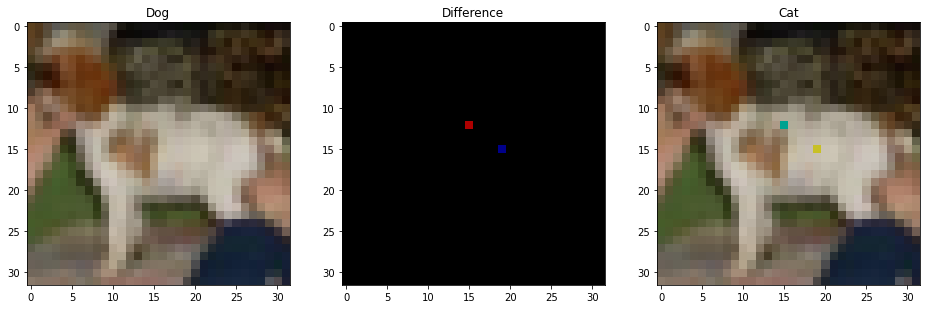

In [9]:
k = 12
fig, axes =  plt.subplots(1,3, figsize=(16,12))

axes[0].imshow(original_images[k].cpu())
axes[1].imshow(np.abs(difference[k].cpu()))
axes[2].imshow(adversarial_examples[k].cpu())

axes[0].set_title(f"{names[labels[k]]}")
axes[1].set_title("Difference")
axes[2].set_title(f"{names[prediction[k]]}")

print(success[k])